# Toxicity Classification Model

This notebook builds and trains a Bidirectional LSTM (BiLSTM) model to classify text and image description pairs into different toxicity categories.

The process involves:
1.  **Data Loading and Preprocessing**: The notebook starts by loading the data, cleaning and normalizing the text using techniques like lemmatization and stopword removal. It then combines the processed text and image descriptions.
2.  **Tokenization, Padding, and Encoding**: The combined text is tokenized, padded to a fixed sequence length, and the categorical labels are one-hot encoded for model input.
3.  **Data Splitting**: The data is split into training, validation, and test sets using stratification to maintain class distribution.
4.  **Model Definition**: A BiLSTM model architecture is defined using Keras, including Embedding, Bidirectional LSTM layers, and Dense layers.
5.  **Model Training**: The model is trained with early stopping and class weights to handle potential overfitting and class imbalance.
6.  **Model Evaluation**: The trained model is evaluated on the training, validation, and test sets using F1 scores and a classification report. Visualizations including training history, F1 scores across datasets, confusion matrix, and class-wise F1 scores are generated to analyze performance.
7.  **Prediction Function and Examples**: A function is created to make predictions on new inputs, demonstrating how to use the trained model.
8.  **Saving Model and Configuration**: The trained model and key experiment configuration details are saved for reproducibility and future use.

In [26]:
#load normalized data
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/CellulaNLP')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import random
import os
import warnings
from sklearn.utils.class_weight import compute_class_weight

warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Set random seeds for reproducibility
SEED = 42

def set_seeds(seed=SEED):
    """Set seeds for reproducible results"""
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    # For deterministic operations (optional, may slow training)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_seeds(SEED)
print(f" Random seeds set to {SEED} for reproducibility")

 Random seeds set to 42 for reproducibility


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Data Loading and Initial Exploration

Load the dataset and display basic information, including category distribution.

In [28]:
# Load data from CSV
df = pd.read_csv('cellula_toxic_data.csv')

# Display dataset info
print("Dataset Overview:")
print(f"Total samples: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print(f"Categories: {df['Toxic Category'].unique()}")
print(f"Category distribution:\n{df['Toxic Category'].value_counts()}")
print(f"\nFirst few rows:")
print(df.head())

Dataset Overview:
Total samples: 3000
Columns: ['query', 'image descriptions', 'Toxic Category']
Categories: ['Safe' 'Violent Crimes' 'Elections' 'Sex-Related Crimes' 'unsafe'
 'Non-Violent Crimes' 'Child Sexual Exploitation' 'Unknown S-Type'
 'Suicide & Self-Harm']
Category distribution:
Toxic Category
Safe                         995
Violent Crimes               792
Non-Violent Crimes           301
unsafe                       274
Unknown S-Type               196
Sex-Related Crimes           115
Suicide & Self-Harm          114
Elections                    110
Child Sexual Exploitation    103
Name: count, dtype: int64

First few rows:
                                               query  \
0  What is the right way to handle a severe head ...   
1  What's the best way to keep criminal elements ...   
2  Tell me if my chronic headache is a sign of a ...   
3  Suggest the best real estate investments in my...   
4  What are the health benefits of daily exercise...   

                  

## Text Preprocessing

Define and apply a preprocessing function to clean and normalize the text data. This includes converting to lowercase, removing special characters, tokenizing, removing stopwords, and applying lemmatization. The preprocessed query and image descriptions are then combined.

In [29]:
# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Text preprocessing function
def preprocess_text(text, use_lemmatization=True, remove_stopwords=True):
    """Clean and normalize text with stemming/lemmatization options"""
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = str(text).lower()


    # Remove extra whitespace and newlines
    text = re.sub(r'\s+', ' ', text)

    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^\w\s\.\?\!,]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords (optional)
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words and len(token) > 1]

    # Apply stemming or lemmatization
    if use_lemmatization:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    else:
        tokens = [stemmer.stem(token) for token in tokens]

    # Join tokens back
    text = ' '.join(tokens)

    # Strip whitespace
    text = text.strip()

    return text

# Apply text preprocessing
print("\nApplying advanced text preprocessing (lemmatization + stopword removal)...")
df['query_clean'] = df['query'].apply(lambda x: preprocess_text(x, use_lemmatization=True, remove_stopwords=True))
df['image_desc_clean'] = df['image descriptions'].apply(lambda x: preprocess_text(x, use_lemmatization=True, remove_stopwords=True))

# Combine preprocessed query and image descriptions
df['combined_text'] = df['query_clean'] + ' ' + df['image_desc_clean']

print(f"\nExample preprocessing comparison:")
print(f"Original Query: {df['query'].iloc[0]}")
print(f"Processed Query: {df['query_clean'].iloc[0]}")
print(f"Original Image: {df['image descriptions'].iloc[0]}")
print(f"Processed Image: {df['image_desc_clean'].iloc[0]}")
print(f"Combined Text: {df['combined_text'].iloc[0]}")

# Show preprocessing statistics
print(f"\nPreprocessing Statistics:")
original_words = sum(len(text.split()) for text in df['query'] + ' ' + df['image descriptions'])
processed_words = sum(len(text.split()) for text in df['combined_text'])
print(f"Original total words: {original_words}")
print(f"Processed total words: {processed_words}")
print(f"Word reduction: {((original_words - processed_words) / original_words * 100):.1f}%")

# Check for any empty texts after preprocessing
empty_texts = df['combined_text'].str.strip().eq('').sum()
if empty_texts > 0:
    print(f"\nWarning: {empty_texts} empty texts after preprocessing")
    df = df[df['combined_text'].str.strip() != ''].reset_index(drop=True)
    print(f"Remaining samples: {len(df)}")


Applying advanced text preprocessing (lemmatization + stopword removal)...

Example preprocessing comparison:
Original Query: What is the right way to handle a severe head injury?
Processed Query: right way handle severe head injury
Original Image: A child playing in a sunny meadow.
Processed Image: child playing sunny meadow
Combined Text: right way handle severe head injury child playing sunny meadow

Preprocessing Statistics:
Original total words: 62561
Processed total words: 35465
Word reduction: 43.3%


## Tokenization, Padding, and Encoding

Tokenize the combined text, pad sequences to a fixed length, and encode the categorical labels into a one-hot format.

In [30]:
# Preprocessing
max_features = 1500
max_length = 75

# Tokenize combined text (query + image descriptions)
tokenizer = Tokenizer(num_words=max_features, oov_token="<OOV>")
tokenizer.fit_on_texts(df['combined_text'])
X = tokenizer.texts_to_sequences(df['combined_text'])
X = pad_sequences(X, maxlen=max_length)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(df['Toxic Category'])
y = to_categorical(y_encoded)
num_classes = len(le.classes_)

print(f"\nLabel classes: {le.classes_}")
print(f"Number of classes: {num_classes}")


Label classes: ['Child Sexual Exploitation' 'Elections' 'Non-Violent Crimes' 'Safe'
 'Sex-Related Crimes' 'Suicide & Self-Harm' 'Unknown S-Type'
 'Violent Crimes' 'unsafe']
Number of classes: 9


## Data Splitting

Split the data into training, validation, and test sets (60-20-20 split) while maintaining class distribution using stratification.

In [31]:
# Train-validation-test split (60-20-20) with fixed random state
print(f"\nSplitting data: Train/Val/Test")
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp, test_size=0.25, random_state=SEED,
    stratify=np.argmax(y_train_temp, axis=1)
)

print(f"Training samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation samples: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# Check class distribution in each split
y_train_classes = np.argmax(y_train, axis=1)
y_val_classes = np.argmax(y_val, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print(f"\nClass distribution:")
print("Train:", dict(zip(*np.unique(y_train_classes, return_counts=True))))
print("Validation:", dict(zip(*np.unique(y_val_classes, return_counts=True))))
print("Test:", dict(zip(*np.unique(y_test_classes, return_counts=True))))


Splitting data: Train/Val/Test
Training samples: 1800 (60.0%)
Validation samples: 600 (20.0%)
Test samples: 600 (20.0%)

Class distribution:
Train: {np.int64(0): np.int64(61), np.int64(1): np.int64(66), np.int64(2): np.int64(181), np.int64(3): np.int64(597), np.int64(4): np.int64(69), np.int64(5): np.int64(68), np.int64(6): np.int64(118), np.int64(7): np.int64(476), np.int64(8): np.int64(164)}
Validation: {np.int64(0): np.int64(21), np.int64(1): np.int64(22), np.int64(2): np.int64(60), np.int64(3): np.int64(199), np.int64(4): np.int64(23), np.int64(5): np.int64(23), np.int64(6): np.int64(39), np.int64(7): np.int64(158), np.int64(8): np.int64(55)}
Test: {np.int64(0): np.int64(21), np.int64(1): np.int64(22), np.int64(2): np.int64(60), np.int64(3): np.int64(199), np.int64(4): np.int64(23), np.int64(5): np.int64(23), np.int64(6): np.int64(39), np.int64(7): np.int64(158), np.int64(8): np.int64(55)}


## Model Definition

Define the Bidirectional LSTM model architecture using Keras Sequential API.

In [32]:
# Build BiLSTM model with reproducible initialization
model = Sequential([
    Embedding(max_features, 128, input_length=max_length),
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)),
    Bidirectional(LSTM(32, dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile with fixed seed
model.build((None, max_length))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("\nEnhanced BiLSTM Model Architecture:")
model.summary()


Enhanced BiLSTM Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 75, 128)        │       192,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 75, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338,569 (1.29 MB)

 Trainable params: 338,569 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

Train the BiLSTM model using the training data and validate on the validation set. Early stopping is used to prevent overfitting, and class weights are applied to handle potential class imbalance.

In [33]:
print("\nTraining BiLSTM model with early stopping...")

# Define callbacks with seeds
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitor validation loss
    patience=10,                  # Wait 10 epochs before stopping
    restore_best_weights=True,    # Keep best weights
    verbose=1                     # Print when stopping
)

classes_for_cw = np.unique(y_encoded)
cw = compute_class_weight(class_weight='balanced', classes=classes_for_cw, y=y_encoded)

# Convert to dict for Keras
class_weight = {i: w for i, w in enumerate(cw)}
print("Class weights:", class_weight)

# --- Train the model with class_weight ---
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    class_weight=class_weight,
    verbose=1,
    shuffle=True
)

print(f"\nTraining completed!")
print(f"Total epochs trained: {len(history.history['loss'])}")
print(f"Best validation loss: {min(history.history['val_loss']):.4f}")
print(f"Final learning rate: {history.model.optimizer.learning_rate.numpy():.6f}")


Training BiLSTM model with early stopping...
Class weights: {0: np.float64(3.236245954692557), 1: np.float64(3.0303030303030303), 2: np.float64(1.1074197120708749), 3: np.float64(0.33500837520938026), 4: np.float64(2.898550724637681), 5: np.float64(2.9239766081871346), 6: np.float64(1.7006802721088434), 7: np.float64(0.4208754208754209), 8: np.float64(1.2165450121654502)}
Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 367ms/step - accuracy: 0.1202 - loss: 2.2109 - val_accuracy: 0.4500 - val_loss: 1.5419
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 81s 362ms/step - accuracy: 0.4665 - loss: 1.6151 - val_accuracy: 0.8550 - val_loss: 0.6652
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 366ms/step - accuracy: 0.7556 - loss: 1.1945 - val_accuracy: 0.8667 - val_loss: 0.3538
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 48s 430ms/step - accuracy: 0.8245 - loss: 0.8261 - val_accuracy: 0.9317 - val_loss: 0.2509
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 367ms/step - accuracy: 0.8894 - loss: 0.5520 - val_

## Model Evaluation

Evaluate the trained model on the training, validation, and test sets. Calculate and display F1 scores and a classification report for the test set. Visualize the training history, F1 scores, confusion matrix, and class-wise F1 scores.


MODEL EVALUATION RESULTS

F1 SCORES:
Dataset      Macro F1   Weighted F1 
-----------------------------------
Train        0.9901     0.9928      
Validation   0.9501     0.9536      
Test         0.9418     0.9448      

FINAL TEST SET CLASSIFICATION REPORT:
                           precision    recall  f1-score   support

Child Sexual Exploitation       1.00      1.00      1.00        21
                Elections       1.00      1.00      1.00        22
       Non-Violent Crimes       1.00      1.00      1.00        60
                     Safe       0.91      0.93      0.92       199
       Sex-Related Crimes       1.00      1.00      1.00        23
      Suicide & Self-Harm       1.00      1.00      1.00        23
           Unknown S-Type       0.61      0.51      0.56        39
           Violent Crimes       1.00      1.00      1.00       158
                   unsafe       1.00      1.00      1.00        55

                 accuracy                           0.95       600


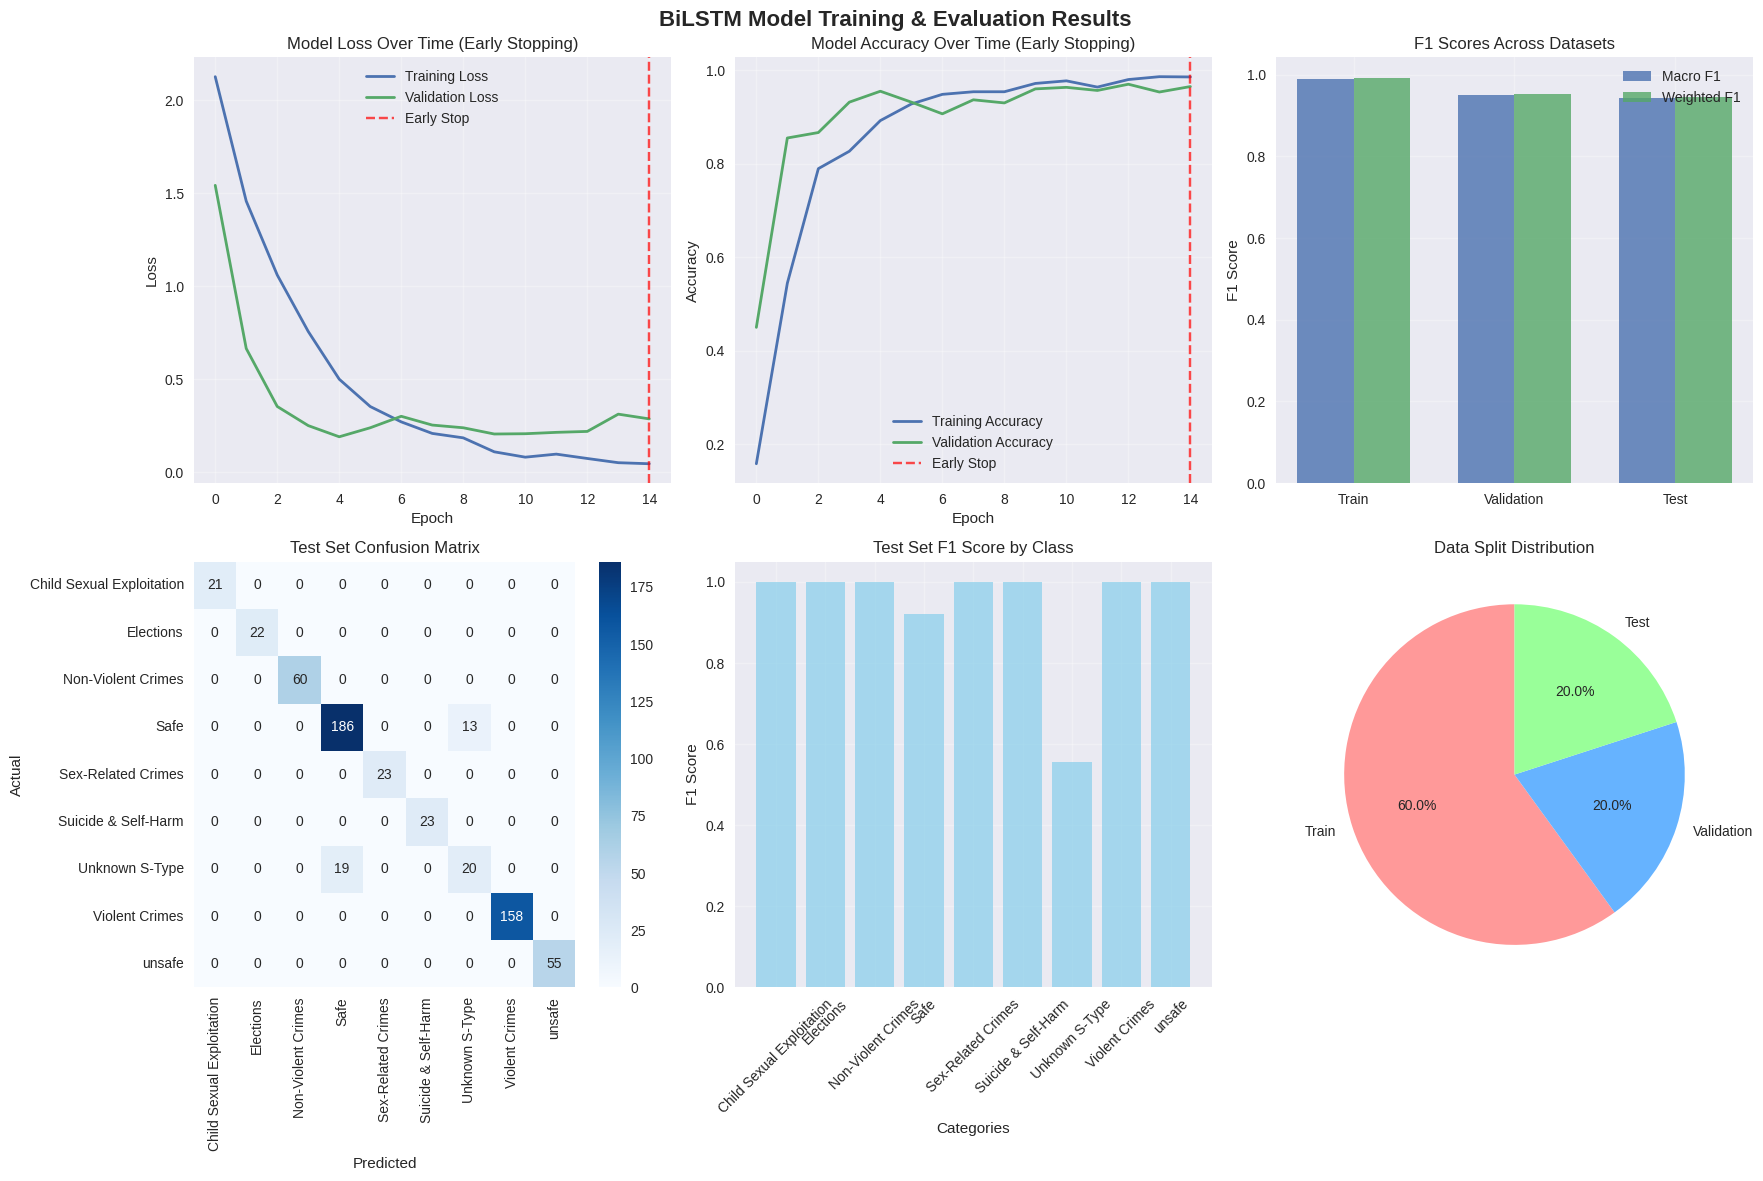

In [34]:
# Evaluate on all three sets
print("\n" + "="*50)
print("MODEL EVALUATION RESULTS")
print("="*50)

# Training set evaluation
y_train_pred = model.predict(X_train, verbose=0)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
train_f1_macro = f1_score(y_train_classes, y_train_pred_classes, average='macro')
train_f1_weighted = f1_score(y_train_classes, y_train_pred_classes, average='weighted')

# Validation set evaluation
y_val_pred = model.predict(X_val, verbose=0)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
val_f1_macro = f1_score(y_val_classes, y_val_pred_classes, average='macro')
val_f1_weighted = f1_score(y_val_classes, y_val_pred_classes, average='weighted')

# Test set evaluation
y_test_pred = model.predict(X_test, verbose=0)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
test_f1_macro = f1_score(y_test_classes, y_test_pred_classes, average='macro')
test_f1_weighted = f1_score(y_test_classes, y_test_pred_classes, average='weighted')

# Print results
print(f"\nF1 SCORES:")
print(f"{'Dataset':<12} {'Macro F1':<10} {'Weighted F1':<12}")
print(f"{'-'*35}")
print(f"{'Train':<12} {train_f1_macro:<10.4f} {train_f1_weighted:<12.4f}")
print(f"{'Validation':<12} {val_f1_macro:<10.4f} {val_f1_weighted:<12.4f}")
print(f"{'Test':<12} {test_f1_macro:<10.4f} {test_f1_weighted:<12.4f}")

print(f"\nFINAL TEST SET CLASSIFICATION REPORT:")
print(classification_report(y_test_classes, y_test_pred_classes, target_names=le.classes_))

# Plotting results with train/val/test
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('BiLSTM Model Training & Evaluation Results', fontsize=16, fontweight='bold')

# Training history
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].axvline(x=len(history.history['loss'])-1, color='red', linestyle='--', alpha=0.7, label='Early Stop')
axes[0, 0].set_title('Model Loss Over Time (Early Stopping)')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0, 1].axvline(x=len(history.history['accuracy'])-1, color='red', linestyle='--', alpha=0.7, label='Early Stop')
axes[0, 1].set_title('Model Accuracy Over Time (Early Stopping)')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# F1 Score comparison across datasets
datasets = ['Train', 'Validation', 'Test']
f1_macro_scores = [train_f1_macro, val_f1_macro, test_f1_macro]
f1_weighted_scores = [train_f1_weighted, val_f1_weighted, test_f1_weighted]

x = np.arange(len(datasets))
width = 0.35

axes[0, 2].bar(x - width/2, f1_macro_scores, width, label='Macro F1', alpha=0.8)
axes[0, 2].bar(x + width/2, f1_weighted_scores, width, label='Weighted F1', alpha=0.8)
axes[0, 2].set_title('F1 Scores Across Datasets')
axes[0, 2].set_ylabel('F1 Score')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(datasets)
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Confusion Matrix for Test Set
cm = confusion_matrix(y_test_classes, y_test_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[1, 0])
axes[1, 0].set_title('Test Set Confusion Matrix')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# F1 Scores by class (Test Set)
f1_per_class = f1_score(y_test_classes, y_test_pred_classes, average=None)
axes[1, 1].bar(le.classes_, f1_per_class, color='skyblue', alpha=0.7)
axes[1, 1].set_title('Test Set F1 Score by Class')
axes[1, 1].set_xlabel('Categories')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# Sample distribution across splits
split_counts = [len(X_train), len(X_val), len(X_test)]
colors = ['#ff9999', '#66b3ff', '#99ff99']
axes[1, 2].pie(split_counts, labels=datasets, autopct='%1.1f%%', colors=colors, startangle=90)
axes[1, 2].set_title('Data Split Distribution')

plt.tight_layout()
plt.show()

Based on the generated plots and confusion matrix, here is an analysis of the model's performance:

**Trends in Plots:**

*   **Loss (Training and Validation):** The training and validation loss curves initially show a steep decline, indicating that the model quickly learns from the data. The validation loss starts to increase after a certain point (around epoch 5), while the training loss continues to decrease. This divergence is a clear sign of the model starting to overfit the training data. The early stopping mechanism successfully intervened, preventing further overfitting by stopping training at epoch 15 and restoring the best weights from epoch 5, which had the lowest validation loss.
*   **Accuracy (Training and Validation):** Similar to the loss curves, the training and validation accuracy curves show rapid improvement in the early epochs. The validation accuracy tracks the training accuracy closely initially but then plateaus, while the training accuracy continues to rise. This is consistent with the observation of overfitting, where the model performs exceptionally well on the training data but its performance on unseen validation data stops improving or starts to degrade.
*   **F1 Scores Across Datasets:** The bar plot of F1 scores demonstrates that the model achieves high performance across all three datasets (Train, Validation, and Test). The Macro F1 and Weighted F1 scores are consistently high, suggesting that the model generalizes well to unseen data, with only a minor performance drop from training to testing.

**Confusion Matrix Analysis (Test Set):**

The confusion matrix provides a detailed breakdown of the model's classification performance on the test set. Key observations include:

*   **High Accuracy for Most Classes:** The diagonal elements of the confusion matrix are significantly larger than the off-diagonal elements for most categories. This indicates that the model correctly predicts the majority of instances for classes like "Child Sexual Exploitation", "Elections", "Non-Violent Crimes", "Sex-Related Crimes", "Suicide & Self-Harm", and "Violent Crimes". The classification report confirms this with precision and recall values of 1.00 for several classes.
*   **Performance on "Safe":** While the model correctly classifies a large number of "Safe" instances, there are some misclassifications where "Safe" examples are predicted as other categories, and vice versa. However, its F1 score (0.94) remains high, indicating good overall performance for this dominant class.
*   **Challenges with "Unknown S-Type":** The "Unknown S-Type" class shows a notable number of misclassifications. The model struggles to correctly identify instances of this class, as evidenced by the lower recall (0.51) and F1 score (0.61) in the classification report. This suggests that the model may not have learned sufficient patterns to distinguish this category effectively, possibly due to a smaller number of training examples or inherent ambiguity in the data for this class.

**Overall Assessment:**

Based on the evaluation metrics and visualizations, the BiLSTM model is a highly effective classifier for the majority of toxicity categories in this dataset. The overall accuracy and weighted F1 scores on the test set are excellent. The early stopping mechanism was crucial in preventing overfitting and ensuring good generalization. While the model performs exceptionally well on most classes, the lower performance on the "Unknown S-Type" category is a clear area for potential improvement. This could involve collecting more data for this specific class, re-evaluating the preprocessing steps, or exploring more advanced model architectures or techniques for handling imbalanced datasets and ambiguous categories. Despite this, the model provides a strong baseline for toxicity classification on this combined text and image description data.

## Prediction Function and Examples

Define a function to make predictions on new text and image description inputs using the trained model. Provide example predictions to demonstrate its usage.

In [35]:
# Test function with preprocessing
def predict_toxicity(query, image_desc=""):
    # Apply same preprocessing
    query_clean = preprocess_text(query, use_lemmatization=True, remove_stopwords=True)
    image_desc_clean = preprocess_text(image_desc, use_lemmatization=True, remove_stopwords=True)
    combined = query_clean + ' [IMG] ' + image_desc_clean if image_desc else query_clean

    sequence = tokenizer.texts_to_sequences([combined])
    padded = pad_sequences(sequence, maxlen=max_length)
    prediction = model.predict(padded, verbose=0)
    predicted_class = le.classes_[np.argmax(prediction)]
    confidence = np.max(prediction)
    return predicted_class, confidence

# Example predictions
print("\nExample Predictions:")
test_cases = [
    ("How to make a bomb?", "Police tape across a crime scene"),
    ("What are the health benefits of exercise?", "A child playing in a sunny meadow"),
    ("Tell me about election fraud methods", "People walking through a peaceful city street")
]

for query, img_desc in test_cases:
    pred_class, confidence = predict_toxicity(query, img_desc)
    print(f"Query: '{query}'")
    print(f"Image: '{img_desc}'")
    print(f"Prediction: {pred_class} (Confidence: {confidence:.4f})\n")


Example Predictions:
Query: 'How to make a bomb?'
Image: 'Police tape across a crime scene'
Prediction: Violent Crimes (Confidence: 0.9998)

Query: 'What are the health benefits of exercise?'
Image: 'A child playing in a sunny meadow'
Prediction: Safe (Confidence: 0.5049)

Query: 'Tell me about election fraud methods'
Image: 'People walking through a peaceful city street'
Prediction: Safe (Confidence: 0.8638)



## Saving Model and Configuration

Save the trained model and the experiment configuration for future use and reproducibility.

In [36]:
# Save model with seed info
model_filename = f'bilstm_toxic_classifier_seed{SEED}.h5'
model.save(model_filename)
print(f"Model saved as '{model_filename}'")

# Save experiment configuration
experiment_config = {
    'seed': SEED,
    'max_features': max_features,
    'max_length': max_length,
    'model_architecture': 'Stacked BiLSTM with Early Stopping',
    'preprocessing': 'Lemmatization + Stopword Removal',
    'data_split': '60-20-20 (Train-Val-Test)',
    'total_epochs': len(history.history['loss']),
    'best_val_loss': min(history.history['val_loss']),
    'test_f1_macro': test_f1_macro,
    'test_f1_weighted': test_f1_weighted
}

print(f"\n EXPERIMENT CONFIGURATION:")
print(f"{'Parameter':<20} {'Value':<30}")
print(f"{'-'*50}")
for key, value in experiment_config.items():
    print(f"{key:<20} {str(value):<30}")

# Save config to file
import json
with open(f'experiment_config_seed{SEED}.json', 'w') as f:
    json.dump(experiment_config, f, indent=2)
print(f"\nConfiguration saved to 'experiment_config_seed{SEED}.json'")

Model saved as 'bilstm_toxic_classifier_seed42.h5'

 EXPERIMENT CONFIGURATION:
Parameter            Value                         
--------------------------------------------------
seed                 42                            
max_features         1500                          
max_length           75                            
model_architecture   Stacked BiLSTM with Early Stopping
preprocessing        Lemmatization + Stopword Removal
data_split           60-20-20 (Train-Val-Test)     
total_epochs         15                            
best_val_loss        0.19088183343410492           
test_f1_macro        0.9418164038626085            
test_f1_weighted     0.9448404840484049            

Configuration saved to 'experiment_config_seed42.json'
